<a href="https://colab.research.google.com/github/troshov/ML/blob/main/%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C_LLM_onto_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Планы

Онтологическая модель строится на основе кластеризации текстовых данных с последующим преобразованием кластеров в иерархию классов и подклассов. Основные этапы:

Предобработка текста (токенизация, удаление стоп-слов).

Векторизация текста.

Кластеризация (K-Means, иерархическая кластеризация).

Построение иерархии (автоматическая группировка кластеров в таксономию).

Извлечение связей (анализ совместной встречаемости терминов).

Для оценки качества кластеризации:

Silhouette Score

Оценивает компактность и разделимость кластеров.
Диапазон: [-1, 1] (чем ближе к 1, тем лучше).

Calinski-Harabasz Index

Отношение дисперсии между кластерами к дисперсии внутри кластеров.
Чем выше, тем лучше.

Davies-Bouldin Index

Оценивает среднее сходство кластеров.
Чем ближе к 0, тем лучше.

Процент некластеризованных элементов.
Доля объектов, не попавших ни в один кластер.

Есть 2 основнызх метода для построения онтологической модели: автоматический и полуавтоматический.

Автоматический метод группирует похожие объекты, извлекает ключевые слова. Метод очень быстрый, но присутствуют шумы и не создается иерархия, сложно делать автоматическое создание групп.

Полуавтоматический метод позволяет добавлять связи между классами и вносить мелкие коррективы.

Для малого числа данных лучше всего подходит полуавтоматический метод (предобработка и последующая ручная проверка)

Для среднего числа данных полуавтоматический метод также работает, но ручная проверка уже будет занимать время

Для большого числа данных без автоматического построения модели не обойтись.

#Импорты

In [42]:
# Импорты необходимых библиотек
import pandas as pd  # Для работы с табличными данными
import nltk  # Библиотека для обработки естественного языка
from nltk.tokenize import RegexpTokenizer  # Токенизатор
from nltk.corpus import stopwords  # Стоп-слова
from sklearn.feature_extraction.text import TfidfVectorizer  # Векторизация текста
from sklearn.cluster import KMeans  # Кластеризация
from sklearn.metrics import silhouette_score  # Метрика качества кластеризации
from sklearn.model_selection import ParameterGrid  # Подбор параметров
import re  # Регулярные выражения
from pymorphy3 import MorphAnalyzer  # Морфологический анализатор для русского языка
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [43]:
pip install pymorphy3

#Добавление данных

In [44]:
df = pd.read_excel("Набор данных Студентам.xlsx")

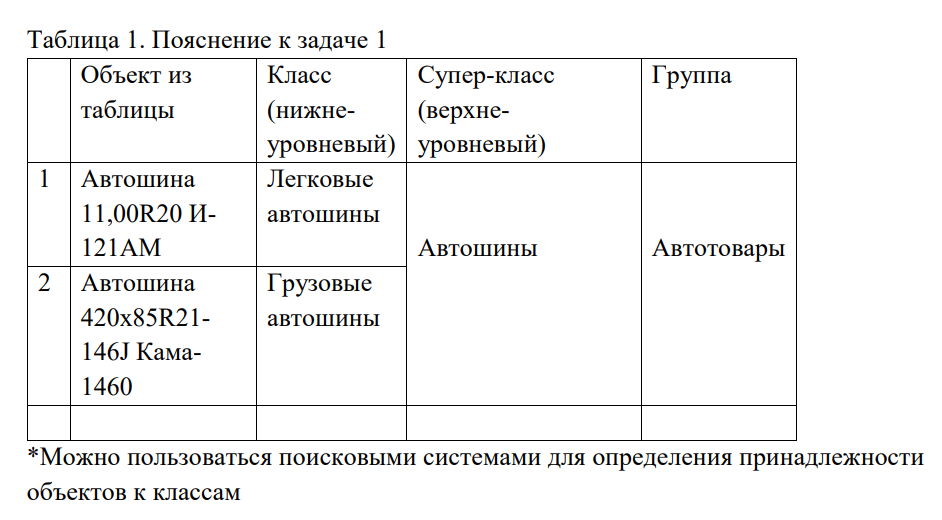

#Оценим, с чем придется иметь дело

In [45]:
df

,Raw_data,ID
0,"IP-камера TRASHPIR TR-D2223W, промышленная",1
1,"IP-камера TRASPIIR TR-D32565413 v 2 2.8, ударо...",2
2,Авиакеросин Т-1,3
3,Автокамера 11.00-20/11.00,4
4,"Автошина 11,00R24",5
...,...,...
175,Лопата штык-ая промышленная 140 см,176
176,Лопатка для чистки /12/240,177
177,Лоток 204х240х80,178
178,"Лоток OSTEC металлический цинк 50х50 мм,",179


Как мы видим, таблица полностью состоит из текстовых наименований и их уникальных ID, повторов нет, методы числового анализа не помогут (у нас текст)

#Методы для проведения онтологии

In [46]:
class OntologyBuilder:
    def __init__(self, data: pd.DataFrame, text_column: str):
        """
        Инициализация класса для построения онтологии

        Параметры:
        data - DataFrame с исходными данными
        text_column - название столбца с текстовыми данными для анализа
        """
        self.data = data
        self.text_column = text_column
        self.tokenizer = RegexpTokenizer(r'\w+')  # Токенизатор, выделяющий слова
        # Стоп-слова русского языка + технические стоп-слова (единицы измерения и т.п.)
        self.stop_words = set(stopwords.words('russian')).union(
            {'мм', 'кг', 'шт', 'гост', 'ту', 'хл', 'см', 'л', 'тб'})
        self.morph = MorphAnalyzer()  # Морфологический анализатор
        self.vectorizer = None  # Векторизатор текста (будет инициализирован позже)
        self.kmeans = None  # Модель кластеризации (будет инициализирована позже)

    def _normalize_word(self, word: str) -> str:
        """Приведение слова к нормальной форме (лемматизация)"""
        return self.morph.parse(word)[0].normal_form if self.morph.parse(word) else word

    def _preprocess_text(self) -> None:
        """
        Предварительная обработка текста:
        - Токенизация
        - Приведение к нижнему регистру
        - Удаление стоп-слов
        - Лемматизация
        - Удаление цифр и специфических паттернов (например, размеров)
        """
        self.data['tokens'] = self.data[self.text_column].astype(str).apply(self.tokenizer.tokenize)
        self.data['filtered_tokens'] = self.data['tokens'].apply(
            lambda tokens: [self._normalize_word(w.lower()) for w in tokens
                          if (w.lower() not in self.stop_words and
                              not w.isdigit() and
                              len(w) > 2 and
                              # Исключение паттернов типа "10x20", "5*3" и т.п.
                              not re.match(r'^\d+[.,]?\d*[xх×*]\d+[.,]?\d*$', w))]
        )
        # Соединение токенов обратно в строку для векторизации
        self.data['text_for_clustering'] = self.data['filtered_tokens'].apply(' '.join)

    def _find_best_vectorizer_params(self, text_data):
        """
        Автоматический подбор оптимальных параметров для векторизации текста
        с использованием поиска по сетке параметров (Grid Search)

        Возвращает:
        - Лучшие параметры
        - Лучшую матрицу векторизованных данных
        """
        param_grid = {
            'max_features': [250, 300, 350, 400],  # Максимальное количество признаков
            'ngram_range': [(1,2), (1,3)],  # Диапазон n-грамм
            'min_df': [1, 2, 3, 4],  # Минимальная частота слова
            'max_df': [0.8, 0.85, 0.9, 0.95]  # Максимальная частота слова
        }

        best_score, best_params, best_X = -1, {}, None

        # Перебор всех комбинаций параметров
        for params in ParameterGrid(param_grid):
            vectorizer = TfidfVectorizer(**params)
            X = vectorizer.fit_transform(text_data)

            # Определение числа кластеров адаптивно к размеру данных
            n_clusters = min(10, len(text_data)//10)
            labels = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit_predict(X)
            score = silhouette_score(X, labels)  # Оценка качества кластеризации

            if score > best_score:
                best_score, best_params, best_X = score, params, X

        print(f"Оптимальные параметры:\n{best_params}\nПредварительный Silhouette: {best_score:.3f}")
        return best_params, best_X

    def _vectorize_text(self) -> None:
        """Векторизация текста с оптимальными параметрами"""
        best_params, X = self._find_best_vectorizer_params(self.data['text_for_clustering'])
        self.vectorizer = TfidfVectorizer(**best_params)
        self.X = X if X is not None else self.vectorizer.fit_transform(self.data['text_for_clustering'])

    def _cluster_data(self, n_clusters: int) -> None:
        """Кластеризация данных методом K-means"""
        self.kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42, init='k-means++', max_iter=300)
        self.data['class_cluster'] = self.kmeans.fit_predict(self.X)

    def find_optimal_clusters(self, max_clusters: int = 25) -> int:
        """
        Определение оптимального числа кластеров с помощью silhouette score

        Параметры:
        max_clusters - максимальное число кластеров для проверки

        Возвращает:
        optimal_clusters - оптимальное число кластеров
        """
        best_score, optimal_clusters = -1, 2

        for n in range(2, max_clusters + 1):
            labels = KMeans(n_clusters=n, n_init='auto', random_state=42).fit_predict(self.X)
            score = silhouette_score(self.X, labels)
            if score > best_score:
                best_score, optimal_clusters = score, n

        return optimal_clusters

    def extract_group_keywords(self, n_keywords: int = 5) -> dict:
        """
        Извлечение ключевых слов для каждого кластера

        Параметры:
        n_keywords - количество ключевых слов для каждого кластера

        Возвращает:
        Словарь, где ключи - ID кластеров, значения - списки ключевых слов
        """
        return {
            cluster_id: [word for word, _ in nltk.FreqDist(
                token for sublist in self.data[self.data['class_cluster'] == cluster_id]['filtered_tokens']
                for token in sublist
            ).most_common(n_keywords)]
            for cluster_id in self.data['class_cluster'].unique()
        }

    def assign_to_group(self, group_keywords: dict) -> None:
        """
        Назначение записей кластерам на основе ключевых слов

        Параметры:
        group_keywords - словарь с ключевыми словами для каждого кластера
        """
        self.data['group'] = self.data.apply(
            lambda row: next(
                (f"Cluster {cid}" for cid, keywords in group_keywords.items()
                 if any(kw in ' '.join(row['filtered_tokens']) for kw in keywords)),
                "Не определено"
            ),
            axis=1
        )

    def build_ontology(self, n_class_clusters: int = 20) -> None:
        """
        Основной пайплайн построения онтологии

        Этапы:
        1. Предварительная обработка текста
        2. Векторизация текста
        3. Определение оптимального числа кластеров
        4. Кластеризация
        5. Извлечение ключевых слов для кластеров
        6. Назначение записей кластерам
        """
        self._preprocess_text()
        self._vectorize_text()

        optimal_clusters = self.find_optimal_clusters(max_clusters=n_class_clusters)
        print(f"\nОптимальное число кластеров: {optimal_clusters}")

        self._cluster_data(optimal_clusters)
        print(f"Final Silhouette Score: {silhouette_score(self.X, self.data['class_cluster']):.3f}")

        group_keywords = self.extract_group_keywords(n_keywords=5)
        self.assign_to_group(group_keywords)

    def evaluate_clusters(self, X, labels):
        """Вычисление метрик качества кластеризации"""
        # Преобразуем sparse matrix в dense array для совместимости с метриками
        X_dense = X.toarray() if hasattr(X, "toarray") else X

        return {
            "Silhouette": silhouette_score(X_dense, labels),
            "Calinski-Harabasz": calinski_harabasz_score(X_dense, labels),
            "Davies-Bouldin": davies_bouldin_score(X_dense, labels),
            "Unclustered_%": (labels == -1).mean() * 100
        }

    def generate_report(builder):
        report = f"""
        ОТЧЕТ О ПОСТРОЕНИИ ОНТОЛОГИИ
        ============================
        Общее количество записей: {len(builder.data)}
        Число кластеров: {len(builder.data['group'].unique())}
        Метрики качества:
        - Silhouette Score: {silhouette_score(builder.X, builder.data['class_cluster']):.2f}
        - Coverage: {(builder.data['group'] != 'Не определено').mean()*100:.1f}%

        Топ-5 крупнейших кластеров:
        {builder.data['group'].value_counts().head()}
        """
        print(report)

        print("Примеры кластеров:")
        for cluster in builder.data['group'].unique()[:3]:
            examples = builder.data[builder.data['group'] == cluster]['Raw_data'].head(3)
            print(f"\n{cluster}:\n{examples.to_string(index=False)}")

#Проверка на данных

In [47]:
# Загрузка данных
df = pd.read_excel('Набор данных Студентам.xlsx')
print(f"Данные успешно загружены. Записей: {len(df)}")

# Инициализация и построение онтологии
builder = OntologyBuilder(df, text_column='Raw_data')
builder.build_ontology(n_class_clusters=25)

# Вычисление метрик качества
metrics = builder.evaluate_clusters(builder.X, builder.data['class_cluster'])
print("\nОценка качества кластеризации:")
for metric, value in metrics.items():
    metric_name = metric.replace("_", " ").title()
    print(f"{metric_name}: {value:.3f}" if isinstance(value, float) else f"{metric_name}: {value}")

# Генерация и вывод отчета
print("\n" + "="*50)
builder.generate_report()
print("="*50 + "\n")

# Сохранение результатов
output_filename = "ontology_results.xlsx"
builder.data.to_excel(output_filename, index=False)
print(f"Результаты сохранены в файл: {output_filename}")

# Вывод сокращенной версии результатов
print("\nПервые 10 записей с кластерами:")
print(builder.data[['Raw_data', 'group']].head(10).to_string(index=False))

# Вывод уникальных групп и ключевых слов
print("\nУникальные группы:")
print(*builder.data['group'].unique(), sep=", ")

print("\nКлючевые слова по кластерам:")
for cluster_id, keywords in sorted(builder.extract_group_keywords(5).items()):
    print(f"[Кластер {cluster_id}]: {', '.join(keywords)}")

Данные успешно загружены. Записей: 180
Оптимальные параметры:
{'max_df': 0.8, 'max_features': 250, 'min_df': 4, 'ngram_range': (1, 2)}
Предварительный Silhouette: 0.567

Оптимальное число кластеров: 25
Final Silhouette Score: 0.931

Оценка качества кластеризации:
Silhouette: 0.931
Calinski-Harabasz: 193.603
Davies-Bouldin: 0.353
Unclustered %: 0.000


        ОТЧЕТ О ПОСТРОЕНИИ ОНТОЛОГИИ
        Общее количество записей: 180
        Число кластеров: 20
        Метрики качества:
        - Silhouette Score: 0.93
        - Coverage: 78.9%
        
        Топ-5 крупнейших кластеров:
        group
Не определено    38
Cluster 1        16
Cluster 19       13
Cluster 24       13
Cluster 2        12
Name: count, dtype: int64
        
Примеры кластеров:

Cluster 15:
        IP-камера TRASHPIR TR-D2223W, промышленная
IP-камера TRASPIIR TR-D32565413 v 2 2.8, удароп...
                         Автокамера 11.00-20/11.00

Не определено:
                    Авиакеросин Т-1
Агрегат насосный 12,5/100.3

#Оценка результатов

Silhouette Score (0.931) - кластеры хорошо разделены

Нулевой процент некластеризованных элементов - все данные распределены

Calinski-Harabasz (193.6) - хорошая плотность кластеров

78.9% записей попало в тематические кластеры

#Что можно улучшить

Направления развития:
1. **Гибридная кластеризация** (K-Means + иерархическая)
2. **Автоматическое именование классов** через LLM (GPT-4)
3. **Визуальный интерфейс** для ручной коррекции (Streamlit)